
Bad key "text.kerning_factor" on line 4 in
C:\Users\Admin\.conda\envs\tf36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            4
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                21
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              s

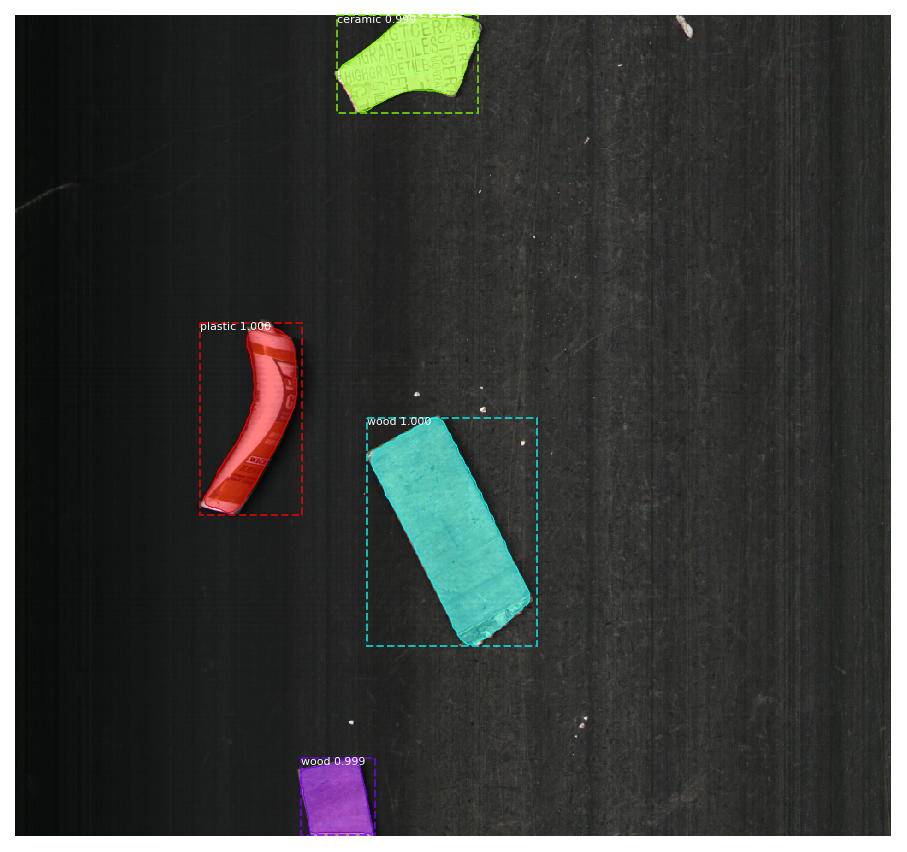

 data 323 /  1011
loading val data 324 /  1011
loading val data 325 /  1011
loading val data 326 /  1011
loading val data 327 /  1011
loading val data 328 /  1011
loading val data 329 /  1011
loading val data 330 /  1011
loading val data 331 /  1011
loading val data 332 /  1011
loading val data 333 /  1011
loading val data 334 /  1011
loading val data 335 /  1011
loading val data 336 /  1011
loading val data 337 /  1011
loading val data 338 /  1011
loading val data 339 /  1011
loading val data 340 /  1011
loading val data 341 /  1011
loading val data 342 /  1011
loading val data 343 /  1011
loading val data 344 /  1011
loading val data 345 /  1011
loading val data 346 /  1011
loading val data 347 /  1011
loading val data 348 /  1011
loading val data 349 /  1011
loading val data 350 /  1011
loading val data 351 /  1011
loading val data 352 /  1011
loading val data 353 /  1011
loading val data 354 /  1011
loading val data 355 /  1011
loading val data 356 /  1011
loading val data 357 /  1

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)

# Import Mask RCNN

from confuse import utils
import mrcnn.model as modellib
from mrcnn import visualize
from samples.cdw import cdw


# To find local version of the library

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
os.environ['CUDA_VISIBLE_DEVICES']='1'
# Local path to trained weights file
# CDW_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_cdw_0020.h5")
CDW_MODEL_PATH = 'E:/20201203/model/rgbh/logs/cdw20210125T1634/mask_rcnn_cdw_0120.h5'
# Directory of images to run detection on
#IMAGE_DIR = os.path.join("E:\DataSet\CDWdevkit\CDW2020\\Hyperspec_test14\\")
#IMAGE_DIR = os.path.join("E:\DataSet\CDWdevkit\CDW2020\\Image_test\\")
IMAGE_DIR ='E:/20201203/val/image'



class InferenceConfig(cdw.CDWConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.7

config = InferenceConfig()
config.display()

#%% md

## Create Model and Load Trained Weights

#%%

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=CDW_MODEL_PATH, config=config)

# Load weights trained on MS-COCO
model.load_weights(CDW_MODEL_PATH, by_name=True) #, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])
#model.keras_model.save('mask_rcnn.h5')

class_names = ['BG','concrete','gray','red','wood','plaster','plastic','ceramic','carton']

# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
img_name = os.path.join(IMAGE_DIR, random.choice(file_names))
image = skimage.io.imread(img_name)
height_name = img_name.replace('/image', '/Height')
height = skimage.io.imread(height_name)
height = np.expand_dims(height, axis=-1)
image = np.concatenate([image, height], axis=-1)


print(image.shape)

# Run detection
import time
t1=time.clock()
results = model.detect([image], verbose=1)
print("time:",time.clock()-t1)
# Visualize results
r = results[0][0]


# print(image[:,:,:3])
# print(r['rois'])
# print(r['masks'], r['class_ids'])
# print(class_names)
visualize.display_instances(image[:,:,:3], r['rois'], r['masks'], r['class_ids'],
                            class_names, r['scores'])
# print( r['class_ids'])

# Validation dataset
dataset_root='E:/20201203'
dataset= cdw.CDWDataset()
#dataset.load_cdw(dataset_root, json_dir="Annotation",img_dir='Hyperspec_',hyper=True)
#dataset.load_cdw(dataset_root, json_dir="Annotation",img_dir=None,hyper=False)
dataset.load_cdw(dataset_root, "val")
dataset.prepare()
print('val data prepared')



In [2]:

gt_tot = np.array([])
pred_tot = np.array([])
image, image_meta, gt_class_id, gt_bbox, gt_mask = \
            modellib.load_image_gt(dataset, config,
                                   1,
                                   use_mini_mask=False,

                                   )
results = model.detect([image], verbose=0)
# Compute AP
r = results[0][0]

#compute gt_tot and pred_tot
gt, pred = utils.gt_pred_lists(gt_class_id, gt_bbox, r['class_ids'], r['rois'])
gt_tot = np.append(gt_tot, gt)
pred_tot = np.append(pred_tot, pred)

# print("the actual len of the gt vect is : ", len(gt_tot))
# print("the actual len of the pred vect is : ", len(pred_tot))
# print("Ground truth object : "+dataset.class_names[gt])
# print("Predicted object : "+dataset.class_names[pred])
# dataset.class_names[[1,2]]

import imgaug
import time
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    AP50s = []
    AP75s = []
    #ground-truth and predictions lists
    gt_tot = np.array([])
    pred_tot = np.array([])
    count = 0
    gt_class_id_number=0
    gt_number=0
    for image_id in image_ids:
        # Load image
        print(count)
        count+=1
        image, image_meta, gt_class_id, gt_bbox, gt_mask = \
            modellib.load_image_gt(dataset, config,
                                   image_id,
                                   use_mini_mask=False,

                                   )
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0][0]
        gt_class_id_number=gt_class_id_number+len(gt_class_id)
        #compute gt_tot and pred_tot
        gt, pred = utils.gt_pred_lists(gt_class_id, gt_bbox, r['class_ids'], r['rois'])
        gt_tot = np.append(gt_tot, gt)
        pred_tot = np.append(pred_tot, pred)
        gt_number=gt_number+len(gt)
        #check if the vectors len are equal
        # print("the actual len of the gt vect is : ", len(gt_tot))
        # print("the actual len of the pred vect is : ", len(pred_tot))
        # print("Ground truth object : "+dataset.class_names[gt])
        # print("Predicted object : "+dataset.class_names[pred])

        # visualize.display_instances(image[:,:,:3], r['rois'], r['masks'], r['class_ids'],
        #                     class_names, r['scores'])
        AP, precisions, recalls, overlaps = \
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                             r['rois'], r['class_ids'], r['scores'], r['masks'], 0.75)
        #confuse[gt_class_id[:],r['class_ids'][:]]+=1
        AP75s.append(AP)

        AP, precisions, recalls, overlaps = \
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                             r['rois'], r['class_ids'], r['scores'], r['masks'], 0.5)
        #confuse[gt_class_id[:],r['class_ids'][:]]+=1
        AP50s.append(AP)
    print("测试数量",len(AP50s))
    print('gt_class_id_number',gt_class_id_number)
    print('gt_number',gt_number)
    gt_tot=gt_tot.astype(int)
    pred_tot=pred_tot.astype(int)

    return AP50s, AP75s,gt_tot,pred_tot
AP50s, AP75s,gt_tot,pred_tot = compute_batch_ap(dataset.image_ids)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [3]:
save_dir = "E:/20201203/model/rgbh/confuse"
gt_pred_tot_json = {"gt_tot" : gt_tot, "pred_tot" : pred_tot}
df = pd.DataFrame(gt_pred_tot_json)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
df.to_json(os.path.join(save_dir,"gt_pred_test.json"))
#%%

image, image_meta, gt_class_id, gt_bbox, gt_mask = \
    modellib.load_image_gt(dataset, config,
                           dataset.image_ids[1], use_mini_mask=False)
results = model.detect([image], verbose=0)
t1=time.clock()
utils.compute_overlaps_masks(gt_mask,results[0][0]['masks'])
print("计算mask iou时间",time.clock()-t1)

#%%

a=dataset.image_ids
mAp=np.nanmean(AP50s)
print("mAP @ IoU=50: ", mAp)
mAp=np.nanmean(AP75s)
print("mAP @ IoU=75: ", mAp)

计算mask iou时间 0.015865899999994326
mAP @ IoU=50:  0.9464210032335024
mAP @ IoU=75:  0.928974612892257


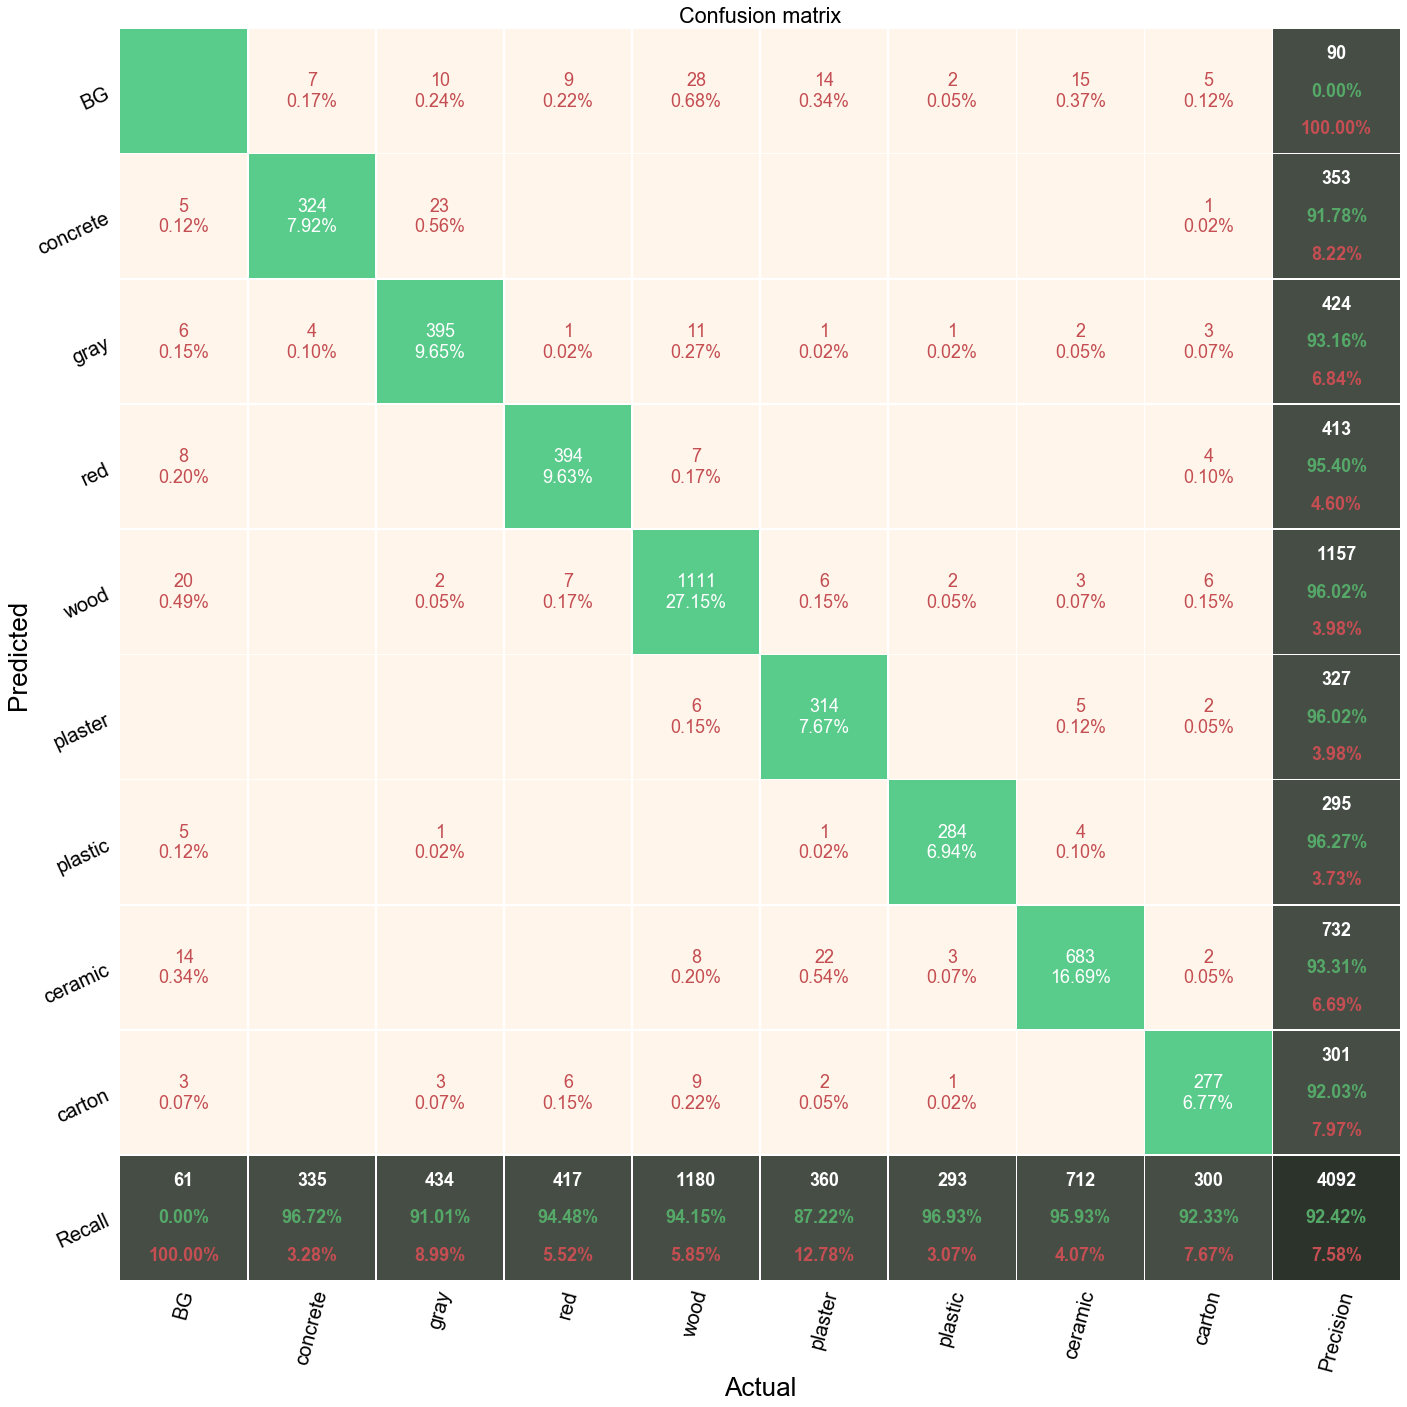

In [4]:
tp, fp, fn = utils.plot_confusion_matrix_from_data(gt_tot, pred_tot, dataset.class_names, fz=18, figsize=(20,20), lw=0.5)